We use data from different measurement campains from which we expect to have the same $\gamma$. We calibrate them together, and therefore share the same $\gamma$. If calibration was previously unsuccesful, due to an insufficient number of calibration baths, or a specific calibration bath could not be used asreference as it appeared to not have a uniform temperature, this might be the solution.

In [1]:
import os

from dtscalibration import read_silixa_files
from dtscalibration.calibrate import calibration_multiple_fix_gamma
from matplotlib import pyplot as plt
import time

%matplotlib inline

## Load the data from the first measurement campain
A double-ended setup

In [2]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'double_ended2')
timezone_netcdf = 'UTC'
timezone_ultima_xml = 'Europe/Amsterdam'
file_ext = '*.xml'

ds1 = read_silixa_files(
    directory=filepath,
    timezone_netcdf=timezone_netcdf,
    timezone_ultima_xml=timezone_ultima_xml,
    file_ext=file_ext).sel(x=slice(-24., 123.))

st_label = 'ST'
ast_label = 'AST'
rst_label = 'REV-ST'
rast_label = 'REV-AST'

sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds1.sections = sections

st_var, resid_st = ds1.variance_stokes(st_label=st_label, suppress_info=1)
ast_var, resid_ast = ds1.variance_stokes(st_label=ast_label, suppress_info=1)
rst_var, resid_rst = ds1.variance_stokes(st_label=rst_label, suppress_info=1)
rast_var, resid_rast = ds1.variance_stokes(st_label=rast_label, suppress_info=1)

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended


## Load data from the second measurement campain
Single-ended setup

In [3]:
# Happens to be the exact same files..
ds2 = read_silixa_files(
    directory=filepath,
    timezone_netcdf=timezone_netcdf,
    timezone_ultima_xml=timezone_ultima_xml,
    file_ext=file_ext).sel(x=slice(-24., 123.))
section_ds2 = sections.copy()
ds2.sections = section_ds2

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended


## Configure calibration setting first measurement campain
A double-ended setup.

See available options: dtscalibration.datastore.calibration_double_ended . Only weighted least squares is supported (`method == 'wls'`), the solver should be sparse (`solver == 'sparse'`), and calculation of the confidence interval should be called in a later stage (`conf_ints == None`).

In [4]:
ds1_kwargs = dict(
    sections=ds1.sections,
    st_label=st_label,
    ast_label=ast_label,
    rst_label=rst_label,
    rast_label=rast_label,
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_c='c',
    store_gamma='gamma',
    store_alphaint='alphaint',
    store_alpha='alpha',
    store_tmpf='TMPF',
    store_tmpb='TMPB',
    store_p_cov='p_cov',
    store_p_sol='p_val',
    variance_suffix='_var',
    method='wls',
    store_tempvar=None,
    conf_ints=None,
    conf_ints_size=None,
    ci_avg_time_flag=False,
    solver='sparse',
    da_random_state=None,
    dtype=None)

## Configure calibration setting second measurement campain
A single-ended setup.

See available options: dtscalibration.datastore.calibration_single_ended . Only weighted least squares is supported (`method == 'wls'`), the solver should be sparse (`solver == 'sparse'`), and calculation of the confidence interval should be called in a later stage (`conf_ints == None`).

In [5]:
ds2_kwargs = dict(
    sections=ds2.sections,
    st_label=st_label,
    ast_label=ast_label,
    st_var=st_var,
    ast_var=ast_var,
    store_c='c',
    store_gamma='gamma',
    store_dalpha='dalpha',
    store_alpha='alpha',
    store_tmpf='TMPF',
    store_p_cov='p_cov',
    store_p_sol='p_val',
    variance_suffix='_var',
    method='wls',
    store_tempvar=None,
    conf_ints=None,
    conf_ints_size=None,
    ci_avg_time_flag=False,
    solver='sparse',
    da_random_state=None,
    dtype=None)

## Perform the actual calibration

`ds_input` is a list that contains a tuple for each measurement campain. Each tuple contains three items. The first is the DataStore obj with all the measured Stokes, second, a string that can either be `'single'` or `'double'`, third, the dictionary with calibration options.

The results are saved inplace, meaning that `ds1` and `ds2` are updated with the calibrated temperature.

In [6]:
# perform a calibration of multiple campains
ds_input = [
    (ds1, 'double', ds1_kwargs),
    (ds2, 'single', ds2_kwargs)
    ]

calibration_multiple_fix_gamma(ds_input)

## Result is stored in the DataStore objects
We can check the gamma is the same for both results

In [7]:
ds1.gamma, ds2.gamma

(<xarray.DataArray 'gamma' ()>
 array(482.51004), <xarray.DataArray 'gamma' ()>
 array(482.51004))

## Now we can compare single ended to double ended

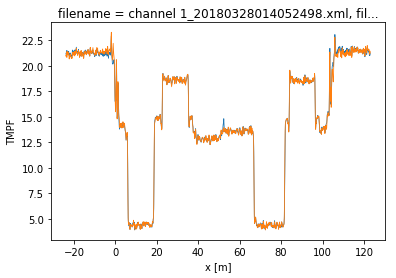

In [8]:
ds1.isel(time=0).TMPF.plot(linewidth=0.8)  # double ended
ds2.isel(time=0).TMPF.plot(linewidth=0.8)  # single ended

We can see the temperature at the internal reference sections to be tilted. Apparently a linearized differential attenuation (single ended setups) is not ideal when you'd want to use the internal reference temperature for calibration.

In [9]:
# ds1.alpha.plot()
# ds2.alpha.plot()